## Code for fitting and plotting fluorescence anisotropy binding data (comparison of models) ##
This script takes one input text file, which contains concentration values ([:,0]), average anisotropy values ([:,1]), and standard deviations ([:,2]) for SERF-U30 binding. In this experiment, the RNA was fluorescently labeled and served as the source of signal for equilibrium binding measurements.


In [1]:
## import packages ##

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import optimize

In [2]:
## load file containing binding data ##

data = np.loadtxt('FA_SERF-U30.txt')

In [3]:
## set variables ##

x = data[:,0]
y = data[:,1]
yerr = data[:,2]

# generate x values covering the range of experimental concentrations for fitting 
xfit = np.arange(min(x)+0.005, max(x)+5, 0.01)

# set constants used for fitting

# Af == anisotropy of unbound fluorescent species (constant)
# Ab == anisotropy of fully bound fluorescent species (constant)
# FAM == concentration of fluorescently labeled RNA (constant)
Af = min(y)
Ab = max(y)
FAM = 0.200

guess = [1, 3] # same initial conditions for all models

## 1:1 binding model (original, no assumptions)

In [4]:
## define 1:1 binding model ("og", no concentration assumptions) (corresponds to Eq. 8 & 9) ##

# Kd == dissociation constant in μM (fitted), guess = 1
# Q == dimensionless correction value to account for differences in absolute fluorescence intensities in free vs. bound states (fitted), guess = 3

def kdfit_og(x, Kd, Q):
    
    FB = (((Kd + x + FAM) - np.sqrt(((Kd + x + FAM) **2) - 4 * x * FAM)) / (2 * FAM))
    
    Aobs = ((Q * FB * Ab) + ((Af * (1 - FB)) / (1 - (FB * (1 - Q)))))
    
    return Aobs

## 1:1 binding model (w/ assumptions)

In [5]:
## define 1:1 binding model ("1to1") assuming that the concentration of U30 is negligibly small (corresponds to Eq. 10 & 9) ##

# Kd == dissociation constant in μM (fitted), guess = 1
# Q == dimensionless correction value to account for differences in absolute fluorescence intensities in free vs. bound states (fitted), guess = 3

def kdfit_1to1(x, Kd, Q):
    
    num = (x / Kd) 
    denom = 1 + num
    
    FB = num / denom
    
    Aobs = ((Q * FB * Ab) + ((Af * (1 - FB)) / (1 - (FB * (1 - Q)))))
    
    return Aobs

## 2:1 binding model (w/ assumptions)

In [6]:
## define 2:1 binding model ("2to1") assuming that the concentration of U30 is negligibly small (corresponds to Eq. 11 & 9) ##

# Kd == dissociation constant in μM (fitted), guess = 1
# Q == dimensionless correction value to account for differences in absolute fluorescence intensities in free vs. bound states (fitted), guess = 3

def kdfit_2to1(x, Kd, Q):
    
    num = (x / Kd) + (x ** 2 / Kd **2)
    denom = 1 + num
    
    FB = num / denom
    
    Aobs = ((Q * FB * Ab) + ((Af * (1 - FB)) / (1 - (FB * (1 - Q)))))
    
    return Aobs

## fitting

In [7]:
## define function for fitting (used for all models)

# model == name of function for desired binding model

def fitforplot(model):
    
    p, pcov = optimize.curve_fit(model, x, y, guess)
    fitted = np.array(model(xfit, p[0], p[1]))
    Kd_err = np.sqrt(np.diag(pcov))
    
    fit_out = [xfit, fitted]
    params_out = [[p[0], p[1]], Kd_err]
    
    return fitted, fit_out, params_out

In [8]:
## fit with all three models ##

fitted1, fit1_out, params1_out = fitforplot(kdfit_og)

fitted2, fit2_out, params2_out = fitforplot(kdfit_1to1)

fitted3, fit3_out, params3_out = fitforplot(kdfit_2to1)

In [23]:
## RUN THIS CELL TO WRITE OUT XY FIT VALUES AND FITTED PARAMETERS ##

# for original 1:1 model:
np.savetxt('og_U30_fit.txt', fit1_out)
np.savetxt('og_U30_pars.txt', params1_out)

# for 1:1 model with assumptions:
np.savetxt('1to1_U30_fit.txt', fit2_out)
np.savetxt('1to1_U30_pars.txt', params2_out)

# for 2:1 model with assumptions:
np.savetxt('2to1_U30_fit.txt', fit3_out)
np.savetxt('2to1_U30_pars.txt', params3_out)

In [9]:
## generate "fitted" values for actual SERF concentrations in dataset (not interpolated) for residuals calculation ##
# from fitting cell above, the fitting parameters for Kd and Q are stored in params{x}_out[0][0] and params{x}_out[0][1]

residuals_og = np.array(kdfit_og(x, params1_out[0][0], params1_out[0][1])) - y

residuals_1to1 = np.array(kdfit_1to1(x, params2_out[0][0], params2_out[0][1])) - y

residuals_2to1 = np.array(kdfit_2to1(x, params3_out[0][0], params3_out[0][1])) - y

Kd_vals = [round(params1_out[0][0], 2), round(params2_out[0][0], 2), round(params3_out[0][0], 2)]
Kd_errs = [round(params1_out[1][0], 1), round(params2_out[1][0], 1), round(params3_out[1][0], 1)]

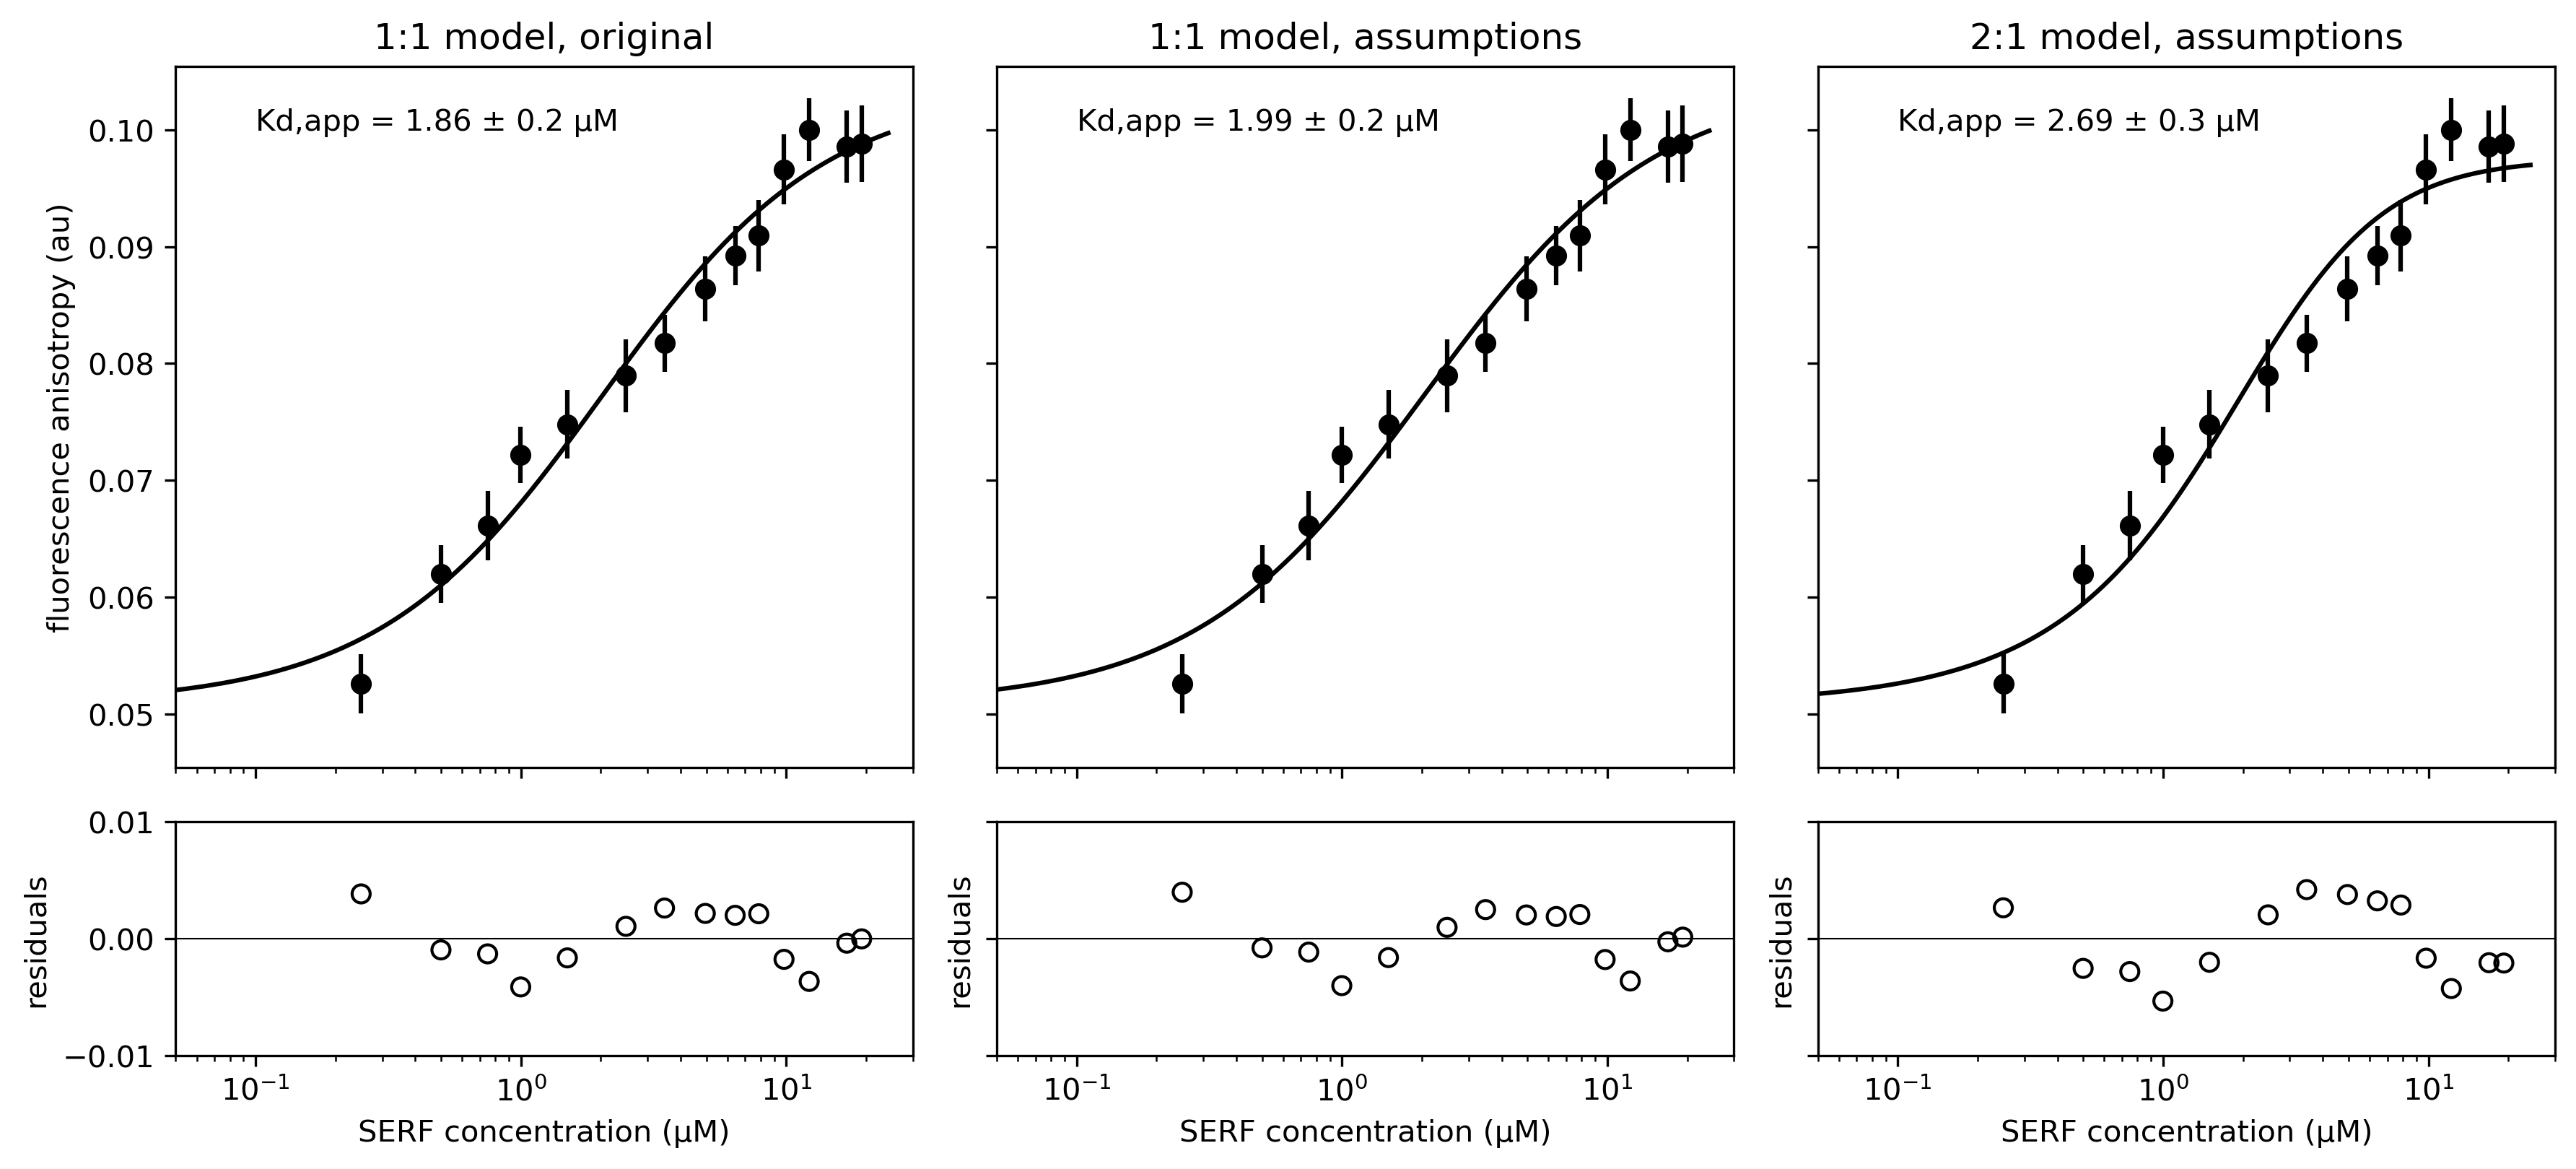

In [14]:
## create subplots to compare fitting models ##
fig, axs = plt.subplots(2, 3, figsize = (12, 5.5), dpi = 300, gridspec_kw={'height_ratios': [3, 1]}, sharex = 'col', sharey = 'row')

# plot raw data (circles), error bars, and fits (solid line) for each binding model 
axs[0, 0].scatter(x, y, color = 'k')
axs[0, 0].plot(xfit, fitted1, color = 'k')
axs[0, 0].errorbar(x, y, yerr = yerr, fmt = 'none', ecolor = 'k')
axs[0, 0].set_title('1:1 model, original')

axs[0, 1].scatter(x, y, color = 'k')
axs[0, 1].plot(xfit, fitted2, color = 'k')
axs[0, 1].errorbar(x, y, yerr = yerr, fmt = 'none', ecolor = 'k')
axs[0, 1].set_title('1:1 model, assumptions')

axs[0, 2].scatter(x, y, color = 'k')
axs[0, 2].plot(xfit, fitted3, color = 'k')
axs[0, 2].errorbar(x, y, yerr = yerr, fmt = 'none', ecolor = 'k')
axs[0, 2].set_title('2:1 model, assumptions')

# plot residuals of fit
axs[1, 0].scatter(x, residuals_og, edgecolor = 'k', facecolor = "None")
axs[1, 1].scatter(x, residuals_1to1, edgecolor = 'k', facecolor = "None")
axs[1, 2].scatter(x, residuals_2to1, edgecolor = 'k', facecolor = "None")

# plotting accessories
for ax in axs[1, :]:
    ax.axhline(y = 0, lw = 0.5, color = 'k')
    ax.set_xlabel('SERF concentration (μM)')
    ax.set_xlim([0.05, 30])
    ax.set_ylabel('residuals')
    ax.set_ylim([-0.01, 0.01])
    
axs[0,0].set_ylabel('fluorescence anisotropy (au)')

for ax, Kd, err in zip(axs[0,:], Kd_vals, Kd_errs):
    text = 'Kd,app = ' +str(Kd)+ ' ± ' +str(err)+ ' μM'
    ax.annotate(text, xy = (0.1, 0.1))

#'Kd,app = ' +str(Kd_vals[i])

for ax in axs.flat:
    ax.set_xscale('log')

plt.tight_layout()

## UNCOMMENT BELOW TO SAVE AS PDF ##
#plt.savefig('SERF-U30_binding_model_comparison.pdf', format = 'pdf', dpi = 300)

plt.show()